<a href="https://colab.research.google.com/github/christinabrnn/Business-Experimentation-and-Causal-Effect/blob/main/Experiment_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
!pip install pingouin
!pip install pandas statsmodels stargazer

from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import statsmodels.stats.power as smp
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from sklearn import preprocessing
from stargazer.stargazer import Stargazer
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


#Simulate a Power Analysis

In [ ]:
# Define parameters
alpha = 0.05
power = 0.8
effect_size = 0.2

# Create a power analysis object
power_analysis = TTestIndPower()

# Calculate required sample size per group
required_n_per_group = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)

print(f"Total required sample size: {required_n_per_group * 2:.0f}")


Total required sample size: 787


Our experiment is well designed for detecting a very large effect. If the motivational quote does not have a large effect on treatment we will need a larger sample to detect an effect

# Data Loading & Preparation

In [ ]:
# Load the long-format treatment/control data
#treatment_df = pd.read_excel("/content/drive/MyDrive/treatmentdata.xlsx", header=None)
treatment_df = pd.read_excel("/content/drive/MyDrive/MSBA/Spring 2025/BA830 M3/BA830 Group Project/BA 830 : Team 5/treatmentdata.xlsx", header=None)
#treatment_df = pd.read_excel("/content/drive/MyDrive/Spring2025/BA830/BA830 Group Project/treatmentdata.xlsx", header=None)

# Load the motivation survey data
#motivation_df = pd.read_excel("/content/drive/MyDrive/MotivationSurveyResults.xlsx")
motivation_df = pd.read_excel("/content/drive/MyDrive/MSBA/Spring 2025/BA830 M3/BA830 Group Project/BA 830 : Team 5/MotivationSurveyResults.xlsx")
#motivation_df = pd.read_excel("/content/drive/MyDrive/Spring2025/BA830/BA830 Group Project/MotivationSurveyResults.xlsx")


#dem_df = pd.read_excel("/content/drive/MyDrive/participants.xlsx")
dem_df = pd.read_excel("/content/drive/MyDrive/MSBA/Spring 2025/BA830 M3/BA830 Group Project/BA 830 : Team 5/participants.xlsx")
#dem_df = pd.read_excel("/content/drive/MyDrive/Spring2025/BA830/BA830 Group Project/participants.xlsx")

In [ ]:
# Set the actual headers from the first row
motivation_df.columns = motivation_df.iloc[0]  # Assign first row as header

# Drop the duplicate row (since it's now in the header)
motivation_df = motivation_df[1:].reset_index(drop=True)

motivation_df.columns = ["Response_ID", "IP_Address","Response_Time","Email", "Day_of_Week", "Motivated_YN", "Motivation_Score"]
motivation_df = motivation_df.copy()

In [ ]:
# Set the actual headers from the first row
dem_df.columns = dem_df.iloc[0]  # Assign first row as header

# Drop the duplicate row (since it's now in the header)
dem_df = dem_df[1:].reset_index(drop=True)
dem_df.head()

,First and Last Name:,Email:,Gender:,Age:,What is your current occupation?,What is your first language?
0,Matt Poon,themattpoon@gmail.com,Male,26,Food Scientist,Chinese
1,Pin-Hao Pan,pp0126@bu.edu,Male,30,Student,Chinese
2,Kai P,arthurpeng7321@gmail.com,Male,27,Engineer,Chinese
3,Zeran Huang,zeranh02@bu.edu,Male,23,Student,Chinese
4,chenhui shen,ryanshen@bu.edu,Male,24,Student,Chinese


In [ ]:
# Rename columns for clarity
dem_df.columns = ["Name", "Email", "Gender", "Age", "Occupation", "First_Language"]
dem_df = dem_df.copy()

In [ ]:
treatment_df.columns = ["Day", "Email", "Group", "Quote"]

In [ ]:
# Convert 'Group' column: Control = 0, Treatment = 1
treatment_df["Group"] = treatment_df["Group"].map({"Control": 0, "Treatment": 1})

# Check if the conversion worked
treatment_df.head()


,Day,Email,Group,Quote
0,Day 1,jastsai@bu.edu,0,No Quote
1,Day 1,xy01@bu.edu,0,No Quote
2,Day 1,laureniwest7@gmail.com,0,No Quote
3,Day 1,atishay@bu.edu,0,No Quote
4,Day 1,quinnvinny478@gmail.com,0,No Quote


In [ ]:
#chnaging the day 1 to actual days to match the motivation survey
day_mapping = {
    1: "Wednesday",
    2: "Thursday",
    3: "Friday",
    "Day 1": "Wednesday",
    "Day 2": "Thursday",
    "Day 3": "Friday"
}

# Replace values in the "Day" column
treatment_df["Day"] = treatment_df["Day"].replace(day_mapping)
treatment_df = treatment_df.copy()

In [ ]:
display(motivation_df.loc[motivation_df['Email'] == 'jylee2@bu.edu'],
        motivation_df.loc[motivation_df['Email'] == 'julia.pell.02@gmail.com'])

#julia.pell.02@gmail.com - maybe the subject put down Thursday for Wednesday cuz the response time is in the morning
#jylee2@bu.edu - not sure why but response time is blank

,Response_ID,IP_Address,Response_Time,Email,Day_of_Week,Motivated_YN,Motivation_Score
67,R_3GHz2kO8l9T46oV,128.197.28.158,NaN,jylee2@bu.edu,Friday,Yes,5
68,R_6PXLhF60GfDgoX6,128.197.28.158,2025-02-20 15:06:00,jylee2@bu.edu,Thursday,No,3
69,R_79QkFyZL5WOaS9X,73.234.212.49,2025-02-19 19:45:00,jylee2@bu.edu,Wednesday,No,1


,Response_ID,IP_Address,Response_Time,Email,Day_of_Week,Motivated_YN,Motivation_Score
64,R_3ElP65rDC8c2yNW,73.190.90.58,2025-02-20 15:07:00,julia.pell.02@gmail.com,Thursday,Yes,6
65,R_32QzksN214DB5hm,174.204.200.65,2025-02-21 15:16:00,julia.pell.02@gmail.com,Friday,No,2
66,R_3cjwE9n1QR4YJBs,73.190.90.58,2025-02-20 09:11:00,julia.pell.02@gmail.com,Wednesday,Yes,8


In [ ]:
#for each person per day how many reponses did they have
# 6 people had 2, so i switched thursday to wendesday for the ones that they responded on first
#should be clean now
#response_rate = motivation_df.groupby('Email')['Email'].value_counts()
response_rate = motivation_df.groupby('Day_of_Week')['Email'].value_counts()
response_rate = response_rate.unstack(level=0).fillna(0)
response_rate

Day_of_Week,Friday,Thursday,Wednesday
Email,,,
a25.akhil@gmail.com,1.0,1.0,0.0
aaron.t.stevenson@gmail.com,0.0,0.0,1.0
achi12@bu.edu,0.0,1.0,1.0
allisonweed8@aol.com,1.0,1.0,1.0
ari2705@bu.edu,0.0,1.0,0.0
atishay@bu.edu,0.0,1.0,0.0
chaitali@bu.edu,1.0,1.0,1.0
chiayung@bu.edu,1.0,1.0,1.0
clamoureux14@gmail.com,1.0,1.0,1.0


In [ ]:
# drop row is motivation score is null
motivation_df = motivation_df.dropna(subset=['Motivation_Score'])

In [ ]:
#merge tables treatment_df and motivation_df on email and day_of_week and Day
#inner to only get rows where people responded ( outer:223-> inner:134 responses)
#total in motivated df - 139 : 5 did not have emails, cannot connect
merged_motivation_treatment_df = pd.merge(treatment_df, motivation_df, left_on=['Email', 'Day'], right_on=['Email', 'Day_of_Week'], how='inner')
merged_motivation_treatment_df

,Day,Email,Group,Quote,Response_ID,IP_Address,Response_Time,Day_of_Week,Motivated_YN,Motivation_Score
0,Wednesday,xy01@bu.edu,0,No Quote,R_31uRBTvIsVryIut,128.197.28.182,2025-02-19 18:20:00,Wednesday,Yes,6
1,Wednesday,rlaalsco@bu.edu,0,No Quote,R_5tJqLU6aMsiGmkH,71.235.135.84,2025-02-19 18:04:00,Wednesday,Maybe,5
2,Wednesday,pp0126@bu.edu,0,No Quote,R_1wvxUwqLBvm23m1,172.56.198.39,2025-02-20 16:55:00,Wednesday,Maybe,8
3,Wednesday,samkessler85@gmail.com,0,No Quote,R_7hAy4JIZDXngMXb,75.214.213.58,2025-02-19 18:15:00,Wednesday,Maybe,4
4,Wednesday,aaron.t.stevenson@gmail.com,0,No Quote,R_5n9qLsby1gf0ufD,70.231.112.102,2025-02-19 18:14:00,Wednesday,Maybe,7
...,...,...,...,...,...,...,...,...,...,...
129,Friday,edwardsher1021@gmail.com,1,Quote 9,R_3CHR2loj64NvVz8,131.179.3.36,2025-02-21 15:33:00,Friday,Yes,7
130,Friday,samkessler85@gmail.com,1,Quote 9,R_1QQUArACePl6Nlu,75.214.213.58,2025-02-21 15:08:00,Friday,Yes,9
131,Friday,allisonweed8@aol.com,1,Quote 9,R_7lreiH9pxSjnGkD,76.19.44.160,2025-02-21 15:11:00,Friday,Yes,8
132,Friday,tharfeed@bu.edu,1,Quote 9,R_7Estrfw71DIJp9H,128.197.28.155,2025-02-21 15:04:00,Friday,Yes,8


In [ ]:
avg = merged_motivation_treatment_df['Motivation_Score'].mean()
print(f"The average motivation score is: {avg}")

The average motivation score is: 5.544776119402985


In [ ]:
#add column to say treatment or control with 0 or 1 based on no quote or quote #
merged_motivation_treatment_df['treatment'] = merged_motivation_treatment_df['Quote'].apply(lambda x: 0 if x == 'No Quote' else 1)
merged_motivation_treatment_df

,Day,Email,Group,Quote,Response_ID,IP_Address,Response_Time,Day_of_Week,Motivated_YN,Motivation_Score,treatment
0,Wednesday,xy01@bu.edu,0,No Quote,R_31uRBTvIsVryIut,128.197.28.182,2025-02-19 18:20:00,Wednesday,Yes,6,0
1,Wednesday,rlaalsco@bu.edu,0,No Quote,R_5tJqLU6aMsiGmkH,71.235.135.84,2025-02-19 18:04:00,Wednesday,Maybe,5,0
2,Wednesday,pp0126@bu.edu,0,No Quote,R_1wvxUwqLBvm23m1,172.56.198.39,2025-02-20 16:55:00,Wednesday,Maybe,8,0
3,Wednesday,samkessler85@gmail.com,0,No Quote,R_7hAy4JIZDXngMXb,75.214.213.58,2025-02-19 18:15:00,Wednesday,Maybe,4,0
4,Wednesday,aaron.t.stevenson@gmail.com,0,No Quote,R_5n9qLsby1gf0ufD,70.231.112.102,2025-02-19 18:14:00,Wednesday,Maybe,7,0
...,...,...,...,...,...,...,...,...,...,...,...
129,Friday,edwardsher1021@gmail.com,1,Quote 9,R_3CHR2loj64NvVz8,131.179.3.36,2025-02-21 15:33:00,Friday,Yes,7,1
130,Friday,samkessler85@gmail.com,1,Quote 9,R_1QQUArACePl6Nlu,75.214.213.58,2025-02-21 15:08:00,Friday,Yes,9,1
131,Friday,allisonweed8@aol.com,1,Quote 9,R_7lreiH9pxSjnGkD,76.19.44.160,2025-02-21 15:11:00,Friday,Yes,8,1
132,Friday,tharfeed@bu.edu,1,Quote 9,R_7Estrfw71DIJp9H,128.197.28.155,2025-02-21 15:04:00,Friday,Yes,8,1


In [ ]:
#if the occupation column says student no matter upper or lower case or if it says college student group it together, add a column
dem_df['Occupation'] = dem_df['Occupation'].str.lower()
dem_df.groupby('Occupation').count()

,Name,Email,Gender,Age,First_Language
Occupation,,,,,
accountant,1,1,1,1,1
ai researcher,1,1,1,1,1
data analysis,1,1,1,1,1
data analytics,1,1,1,1,1
economist,1,1,1,1,1
engineer,3,3,3,3,3
finance,1,1,1,1,1
financial analyst,1,1,1,1,1
food scientist,1,1,1,1,1


In [ ]:
#for these words in a list in the occupation column, put student
#suggestion: employed / unemployed (housewift put as employed)

student_list = ['student']
dem_df['Employment_Status'] = dem_df['Occupation'].apply(lambda x: 'Student' if isinstance(x, str) and any(word in x for word in student_list) else 'Employed')

dem_df

,Name,Email,Gender,Age,Occupation,First_Language,Employment_Status
0,Matt Poon,themattpoon@gmail.com,Male,26,food scientist,Chinese,Employed
1,Pin-Hao Pan,pp0126@bu.edu,Male,30,student,Chinese,Student
2,Kai P,arthurpeng7321@gmail.com,Male,27,engineer,Chinese,Employed
3,Zeran Huang,zeranh02@bu.edu,Male,23,student,Chinese,Student
4,chenhui shen,ryanshen@bu.edu,Male,24,student,Chinese,Student
...,...,...,...,...,...,...,...
67,Ohm,ohmsri@bu.edu,Male,27,student,Thai,Student
68,Phunsok Norboo,phunsokn@bu.edu,Male,25,student,Tibetan,Student
69,Quan Nguyen,qmn@bu.edu,Male,24,student,Vietnamese,Student
70,Juyoung Son,sjy8987@gmail.com,Female,36,housewife,Korean,Employed


In [ ]:
#merge these two tables on email
#OUTSTANDING - 2 PEOPLE RESPONDED BUT USED A DIFFERENT EMAIL (OUTER)
merged_motivation_treatment_dem_df = pd.merge(dem_df, merged_motivation_treatment_df, on='Email', how='inner')
#drop group
merged_motivation_treatment_dem_df = merged_motivation_treatment_dem_df.drop(columns=['Group'])
merged_motivation_treatment_dem_df

,Name,Email,Gender,Age,Occupation,First_Language,Employment_Status,Day,Quote,Response_ID,IP_Address,Response_Time,Day_of_Week,Motivated_YN,Motivation_Score,treatment
0,Pin-Hao Pan,pp0126@bu.edu,Male,30,student,Chinese,Student,Wednesday,No Quote,R_1wvxUwqLBvm23m1,172.56.198.39,2025-02-20 16:55:00,Wednesday,Maybe,8,0
1,Pin-Hao Pan,pp0126@bu.edu,Male,30,student,Chinese,Student,Thursday,No Quote,R_3WwjC4Jf69e0bah,172.56.198.73,2025-02-20 16:57:00,Thursday,Yes,8,0
2,chenhui shen,ryanshen@bu.edu,Male,24,student,Chinese,Student,Wednesday,Quote 8,R_6EmjP00L39GDS9B,128.197.28.140,2025-02-19 18:09:00,Wednesday,No,2,1
3,Huawan Zhong,huawan@bu.edu,Female,24,student,Chinese,Student,Wednesday,Quote 8,R_3EdtQnDQ9JWnJZB,24.62.61.66,2025-02-19 20:09:00,Wednesday,No,2,1
4,Huawan Zhong,huawan@bu.edu,Female,24,student,Chinese,Student,Thursday,Quote 6,R_7I4gHZr3qH1lpvo,24.62.61.66,2025-02-20 19:49:00,Thursday,Yes,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Juyoung Son,sjy8987@gmail.com,Female,36,housewife,Korean,Employed,Thursday,Quote 6,R_4vdMqKCu2S54MB5,110.70.59.109,2025-02-20 20:02:00,Thursday,Yes,8,1
130,Juyoung Son,sjy8987@gmail.com,Female,36,housewife,Korean,Employed,Friday,Quote 4,R_3Du9CTOA29TRxef,50.209.141.242,2025-02-21 17:12:00,Friday,Yes,9,1
131,Jungmin Kwon,jmkwon0601@gmail.com,Male,36,ai researcher,Korean,Employed,Wednesday,Quote 5,R_3s0UdKMHr5Ho2E0,12.10.41.138,2025-02-20 12:58:00,Wednesday,Yes,9,1
132,Jungmin Kwon,jmkwon0601@gmail.com,Male,36,ai researcher,Korean,Employed,Thursday,No Quote,R_4qI0Cr3XBLAaqyt,110.70.59.109,2025-02-20 20:03:00,Thursday,Maybe,6,0


In [ ]:
#make it easier to reference
df = merged_motivation_treatment_dem_df

# EDA

In [ ]:
merged_motivation_treatment_dem_df.groupby(['Day','treatment'])[['Motivation_Score']].agg(['mean', 'count'])

Motivation_Score      
                                mean count
Day       treatment                       
Friday    0                 5.470588    17
          1                 6.521739    23
Thursday  0                    5.375    24
          1                 5.782609    23
Wednesday 0                 5.315789    19
          1                 4.892857    28

In [ ]:
merged_motivation_treatment_dem_df.groupby(['Day','treatment','Employment_Status'])[['Motivation_Score']].agg(['mean', 'count'])
#merged_motivation_treatment_dem_df.groupby(['treatment','Employment_Status'])[['Motivation_Score']].agg(['mean', 'count'])

Motivation_Score      
                                                  mean count
Day       treatment Employment_Status                       
Friday    0         Employed                       6.5     8
                    Student                   4.555556     9
          1         Employed                      7.75     8
                    Student                   5.866667    15
Thursday  0         Employed                     6.625     8
                    Student                       4.75    16
          1         Employed                       6.5     8
                    Student                        5.4    15
Wednesday 0         Employed                       6.0     6
                    Student                        5.0    13
          1         Employed                       7.4    10
                    Student                        3.5    18

In [ ]:
merged_motivation_treatment_dem_df.groupby(['Day','treatment'])[['Motivation_Score']].agg(['mean', 'count'])

Motivation_Score      
                                mean count
Day       treatment                       
Friday    0                 5.470588    17
          1                 6.521739    23
Thursday  0                    5.375    24
          1                 5.782609    23
Wednesday 0                 5.315789    19
          1                 4.892857    28

In [ ]:

merged_motivation_treatment_dem_df.groupby(['Day'])[['Motivation_Score']].agg(['mean', 'count'])


Motivation_Score      
                      mean count
Day                             
Friday               6.075    40
Thursday          5.574468    47
Wednesday          5.06383    47

In [ ]:
merged_motivation_treatment_dem_df.groupby(['treatment','Gender'])[['Motivation_Score']].agg(['mean', 'count'])

Motivation_Score      
                             mean count
treatment Gender                       
0         Female         4.916667    24
          Male           5.694444    36
1         Female         5.538462    39
          Male           5.828571    35

## EDA Visuals

<ipython-input-178-48784efed697>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, control_counts[i] + count + 0.5, str(count), ha='center', va='bottom', fontsize=10, color='black')


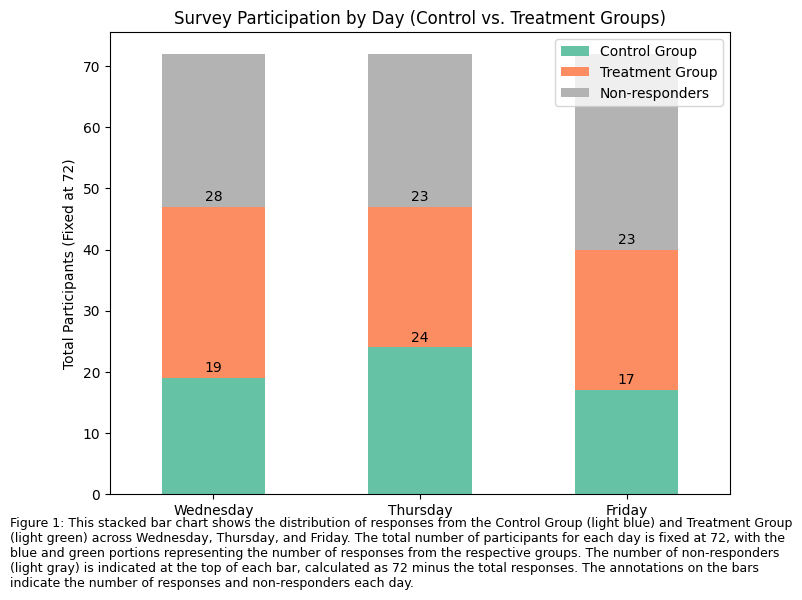

In [ ]:
colors = ["#66C2A5", "#FC8D62","#B3B3B3"]

# Define the correct order for the days
day_order = ["Wednesday", "Thursday", "Friday"]

# Group by 'Day' and count emails (responses)
email_counts = merged_motivation_treatment_dem_df.groupby('Day')['Email'].count()

# Reindex to ensure correct order
email_counts = email_counts.reindex(day_order, fill_value=0)  # Fill missing days with 0 if necessary

# Compute the remaining portion to make the total 72 (non-responders)
remaining_counts = 72 - email_counts

# Count the number of responses from treatment and control groups per day
treatment_counts = merged_motivation_treatment_dem_df[merged_motivation_treatment_dem_df['treatment'] == 1].groupby('Day')['Email'].count()
control_counts = merged_motivation_treatment_dem_df[merged_motivation_treatment_dem_df['treatment'] == 0].groupby('Day')['Email'].count()

# Reindex treatment and control counts to ensure the correct order of days
treatment_counts = treatment_counts.reindex(day_order, fill_value=0)
control_counts = control_counts.reindex(day_order, fill_value=0)

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot responses from control and treatment groups
bars_control = control_counts.plot(kind='bar', color=colors[0], label='Control Group', ax=ax, bottom=0)
bars_treatment = treatment_counts.plot(kind='bar', color=colors[1], label='Treatment Group', bottom=control_counts, ax=ax)

# Plot the non-responders (remaining part) as light gray at the top
bars_nonresponders = remaining_counts.plot(kind='bar', color=colors[2], label='Non-responders', bottom=email_counts, ax=ax)

# Add annotations (number of responses) to the bars
for i, count in enumerate(control_counts):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10, color='black')

for i, count in enumerate(treatment_counts):
    ax.text(i, control_counts[i] + count + 0.5, str(count), ha='center', va='bottom', fontsize=10, color='black')


# Formatting
ax.set_ylabel("Total Participants (Fixed at 72)")
ax.set_title("Survey Participation by Day (Control vs. Treatment Groups)")
ax.set_xlabel('')
ax.set_xticklabels(day_order, rotation=0)  # Ensure correct order and readable labels
ax.legend()

# Add figure description below the plot
fig.text(0,-0.05, "Figure 1: This stacked bar chart shows the distribution of responses from the Control Group (light blue) and Treatment Group (light green) "
                    "across Wednesday, Thursday, and Friday. The total number of participants for each day is fixed at 72, with the blue and green portions representing "
                    "the number of responses from the respective groups. The number of non-responders (light gray) is indicated at the top of each bar, calculated as "
                    "72 minus the total responses. The annotations on the bars indicate the number of responses and non-responders each day.", wrap=True, fontsize=9, ha='left', va='bottom')

plt.show()


In [ ]:
# convert morivation score to int
df['Motivation_Score'] = df['Motivation_Score'].astype(int)

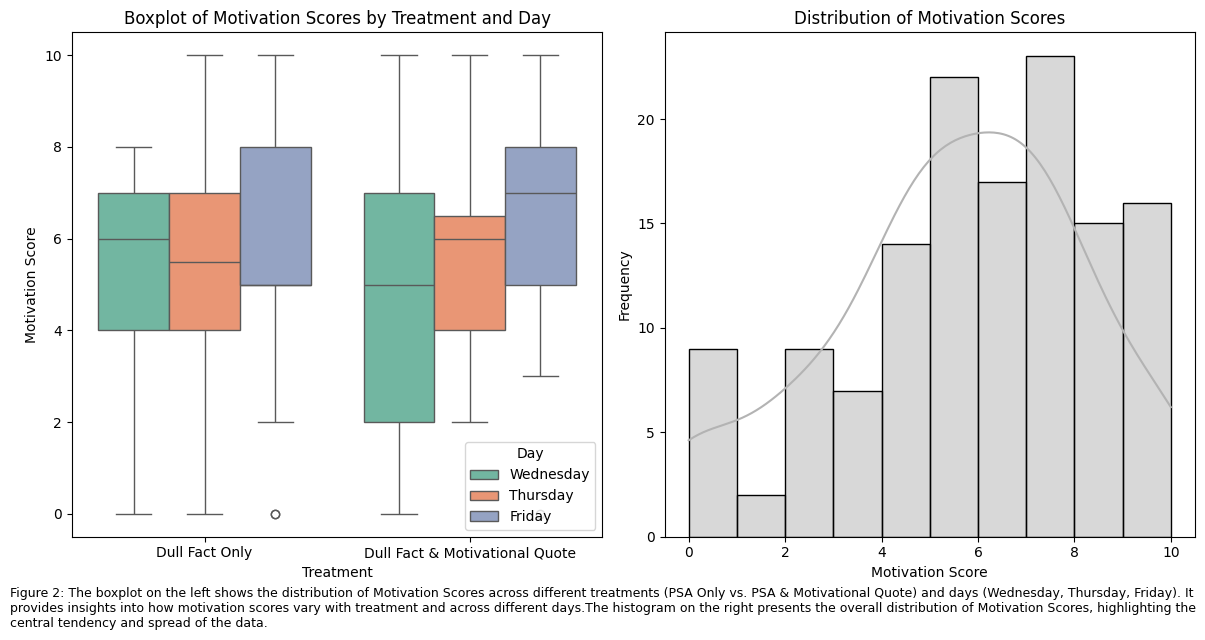

In [ ]:
# Map treatment values to more descriptive labels
merged_motivation_treatment_dem_df['treatment_label'] = merged_motivation_treatment_dem_df['treatment'].map({0: 'Dull Fact Only', 1: 'Dull Fact & Motivational Quote'})

#figure 1
# Set up the figure size
plt.figure(figsize=(12, 6))

# Boxplot to show Motivation_Score distribution across treatment and day
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.boxplot(data=merged_motivation_treatment_dem_df, x='treatment_label', y='Motivation_Score', hue='Day', palette="Set2", hue_order=["Wednesday", "Thursday", "Friday"], meanline = True)
plt.title("Boxplot of Motivation Scores by Treatment and Day")
plt.xlabel("Treatment")
plt.ylabel("Motivation Score")

# Histogram to show the distribution of Motivation_Scores
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.histplot(df['Motivation_Score'], kde=True, color=colors[2], bins=10)
plt.title("Distribution of Motivation Scores")
plt.xlabel("Motivation Score")
plt.ylabel("Frequency")

# Add a comment below the figure
plt.figtext(0.0, -0.05,
            'Figure 2: The boxplot on the left shows the distribution of Motivation Scores across different treatments (PSA Only vs. PSA & Motivational Quote) and days (Wednesday, Thursday, Friday). It provides insights into how motivation scores vary with treatment and across different days.'
            'The histogram on the right presents the overall distribution of Motivation Scores, highlighting the central tendency and spread of the data.',
            wrap=True,fontsize=9, ha='left')

plt.tight_layout()
plt.show()


## Randomization Test

### Z-Score

In [ ]:
#figure 3
def randomization_check(df, day_col='Day', treatment_col='treatment'):

    # Collect results in a list
    results_list = []

    # Identify the unique days in your dataset
    unique_days = df[day_col].unique()

    for d in unique_days:
        # Subset the data for the specific day
        subset = df[df[day_col] == d]

        # Count how many are in treatment (sum of 1's)
        n_treatment = subset[treatment_col].sum()
        n_total = len(subset)

        # Proportion of treatment
        prop_treatment = round((n_treatment / n_total)*100,1)

        # Perform a two-sided proportion z-test against the null hypothesis p=0.5
        z_stat, p_val = proportions_ztest(
            count=n_treatment,
            nobs=n_total,
            value=0.5)

        results_list.append([d, n_total, n_treatment, prop_treatment, p_val])

    results = pd.DataFrame(
        results_list,
        columns=['Day', 'Total Participants', 'Participants in Treatment', 'Treatment Proportion (%)', 'P value'])

    return results

results = randomization_check(df)


print("Figure 3: This table presents the results of a randomization check on those that reponded to the daily \n"
  "survey, showing the distribution of treatment assignments across different days (Wednesday, Thursday, \n"
  "and Friday). The results indicate that the treatment distribution does not significantly deviate from \n"
  "50% across all three days.")

results


Figure 3: This table presents the results of a randomization check on those that reponded to the daily 
survey, showing the distribution of treatment assignments across different days (Wednesday, Thursday, 
and Friday). The results indicate that the treatment distribution does not significantly deviate from 
50% across all three days.


,Day,Total Participants,Participants in Treatment,Treatment Proportion (%),P value
0,Wednesday,47,28,59.6,0.181048
1,Thursday,47,23,48.9,0.884002
2,Friday,40,23,57.5,0.337287


### Balance Check - Regression

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['First_Language']= label_encoder.fit_transform(df['First_Language'])
df['Employment_Status']= label_encoder.fit_transform(df['Employment_Status'])

In [ ]:
rand_check_reg1 = smf.ols('First_Language ~ treatment', data=merged_motivation_treatment_dem_df).fit()
rand_check_reg2 = smf.ols('Employment_Status ~ treatment', data=merged_motivation_treatment_dem_df).fit()

stargazer_2 = Stargazer([rand_check_reg1, rand_check_reg2])


stargazer_2.custom_notes = [
    "Model 1 checks if treatment and control have significant differences in first language.",
    "Model 2 check if treatment and control have significant employment status differences."
]

stargazer_2


# Regressions

In [ ]:
# convert morivation score to int
df['Motivation_Score'] = df['Motivation_Score'].astype(int)

In [ ]:
#table 5
model = smf.ols("Motivation_Score ~ treatment", data=df, cov_type='HC1').fit() #day impact (like original)
model_day = smf.ols("Motivation_Score ~ treatment + C(Day, Treatment(reference = 'Wednesday'))", data = df, cov_type = 'HC1').fit() #day impact of thursday compared to baseline wednesday #the effect of the day
model_day_times = smf.ols("Motivation_Score ~ treatment * C(Day, Treatment(reference = 'Wednesday'))", data = df, cov_type = 'HC1').fit() #day impact of thursday compared to baseline wednesday #dif effect on dif days
model_employment = smf.ols("Motivation_Score ~ treatment * C(Employment_Status, Treatment(reference = 'Employed'))", data=df,  cov_type='HC1').fit()

stargazer = Stargazer([model, model_day, model_day_times, model_employment])

# Add notes to the table
stargazer.custom_notes = [
    "Model 1 examines the effect of treatment on Motivation Score.",
    "Model 2 includes day effects with Thursday compared to Wednesday as the baseline.",
    "Model 3 includes interaction effects between treatment and day, highlighting the differing effects across days.",
    "Model 4 examines the impact of employment status on the treatment effect by comparing Employed vs Unemployed."
]

stargazer

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)
